<a href="https://colab.research.google.com/github/tobyloby12/AMLS-assignment/blob/main/Task%20B/transfer_learning_augmented_task_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# when opening in google colab need to import google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory to github clone
import os
os.chdir('/content/drive/MyDrive/amlsAssignment')

In [ ]:
import pandas as pd
import os

In [ ]:
# put correct path to AMLSassignment github folder
path = '/content/drive/MyDrive/amlsAssignment'

In [ ]:
# using the image_dataset_from_directory function to create the datasets for training of neural networks from the directory created above

from tensorflow.keras.preprocessing import image_dataset_from_directory
os.chdir(path)
train_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset',
    validation_split=0.3,
    subset='training',
    seed=0,
    image_size=(256, 256),
    batch_size=32

)

validate_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset',
    validation_split=0.3,
    subset='validation',
    seed=0,
    image_size=(256, 256),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    os.getcwd() + '/dataset/class_dataset_test',
    seed=0,
    image_size=(256, 256),
    batch_size=32
)

Found 3000 files belonging to 4 classes.
Using 2100 files for training.
Found 3000 files belonging to 4 classes.
Using 900 files for validation.
Found 200 files belonging to 4 classes.


# Augmentation

In [ ]:
# resizing and rescaling images to correct size for neural network to take in
import tensorflow as tf
from tensorflow.keras import layers
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
# data augmentation of random horizontal flips and random rotation applied to images
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.5),
])

In [ ]:
# function to map the images to the augmented function and resizing and preprocessing all images
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)


  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# applying the above function to the three datasets
ds_train = prepare(train_dataset, augment=True, shuffle=True)
ds_validate = prepare(validate_dataset)
ds_test = prepare(test_dataset)

# VGG16

In [ ]:
# importing the vgg16 model
from keras.applications.vgg16 import VGG16

model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

In [ ]:
# making all layers trainable
for layer in model_vgg16.layers:
  layer.trainable = True

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Resizing
from tensorflow.keras import models



# adding layers for intepretation of CNN output and classification layer
model = models.Sequential([
    model_vgg16,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# callbacks to save the best model and stop training early once the validation loss no longer increases
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_VGG16_augment_2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.compile(optimizer=Adam(learning_rate=0.00004), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# training model
history = model.fit(ds_train, validation_data=ds_validate, epochs = 40, callbacks=[es, mc])

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.3500
Epoch 00001: val_accuracy improved from -inf to 0.45000, saving model to best_model_VGG16_augment_2.h5
66/66 [==============================] - 30s 331ms/step - loss: 1.3383 - accuracy: 0.3500 - val_loss: 1.2080 - val_accuracy: 0.4500
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 1.2019 - accuracy: 0.4410
Epoch 00002: val_accuracy did not improve from 0.45000
66/66 [==============================] - 24s 297ms/step - loss: 1.2019 - accuracy: 0.4410 - val_loss: 1.2046 - val_accuracy: 0.4378
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 1.0661 - accuracy: 0.5319
Epoch 00003: val_accuracy improved from 0.45000 to 0.51556, saving model to best_model_VGG16_augment_2.h5
66/66 [==============================] - 26s 328ms/step - loss: 1.0661 - accuracy: 0.5319 - val_loss: 1.0452 - val_accuracy: 0.5156
Epoch 4/40
66/66 [==============================] - ETA: 0

In [ ]:
# loading the best model for evaluation
model.load_weights('best_model_VGG16_augment_2.h5')

In [ ]:
import numpy as np

# creating all predictions so sklearn can be used to evalutate the model
predictions = np.array([])
labels =  np.array([])
for x, y in ds_test:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])


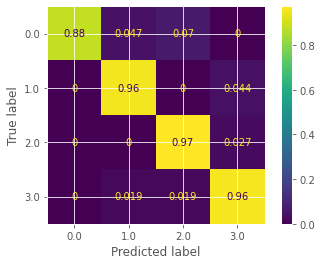

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# displaying confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_VGG16_augment_2.png')

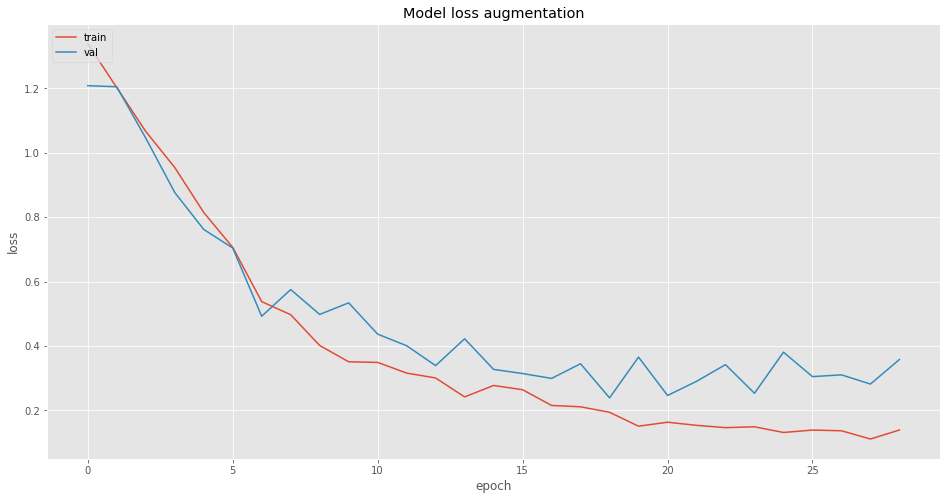

In [ ]:
import matplotlib.pyplot as plt

# plotting loss of model trained
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_VGG16_augment_2.png')
plt.show()

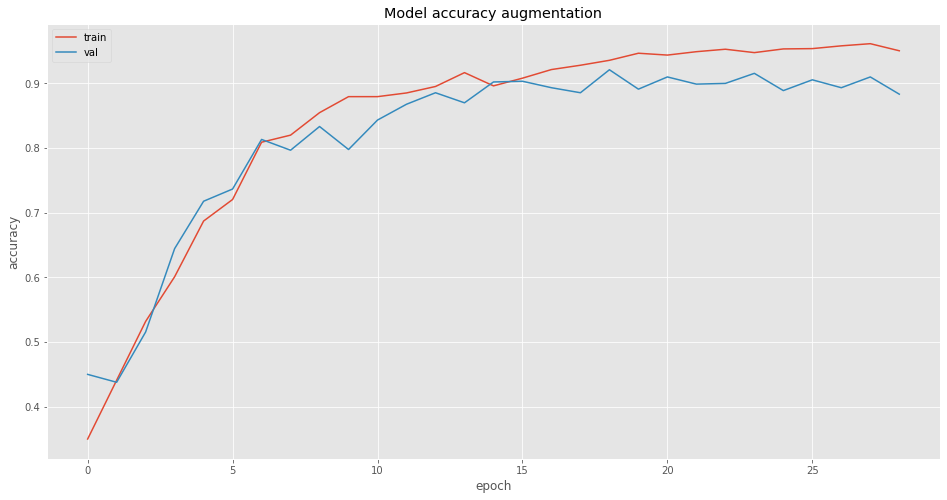

In [ ]:
import matplotlib.pyplot as plt

# plotting accuracy of model trained
plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_VGG16_augment_2.png')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# showing accuracy of model
accuracy = accuracy_score(labels, predictions)
print(accuracy)

0.945


# Xception

In [ ]:
import tensorflow as tf

# importing the Xception model
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None
)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import models

# adding layers for intepretation of CNN output and classification layer
model = models.Sequential([
    xception_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
# making all layers trainable
for layer in model.layers:
  layer.trainable = True

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# callbacks to save the best model and stop training early once the validation loss no longer increases
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_Xception_augment_1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.00004), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# training model
history = model.fit(ds_train, validation_data=ds_validate, epochs = 40, callbacks=[es, mc])

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.6667
Epoch 00001: val_accuracy improved from -inf to 0.44111, saving model to best_model_Xception_augment_1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


66/66 [==============================] - 211s 1s/step - loss: 0.9175 - accuracy: 0.6667 - val_loss: 1.8935 - val_accuracy: 0.4411
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8319
Epoch 00002: val_accuracy improved from 0.44111 to 0.63778, saving model to best_model_Xception_augment_1.h5
66/66 [==============================] - 48s 669ms/step - loss: 0.4566 - accuracy: 0.8319 - val_loss: 1.1550 - val_accuracy: 0.6378
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8810
Epoch 00003: val_accuracy improved from 0.63778 to 0.74111, saving model to best_model_Xception_augment_1.h5
66/66 [==============================] - 48s 660ms/step - loss: 0.3197 - accuracy: 0.8810 - val_loss: 0.7876 - val_accuracy: 0.7411
Epoch 4/40
66/66 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.9143
Epoch 00004: val_accuracy improved from 0.74111 to 0.79444, saving model to best_model_Xception_augment_1.

In [ ]:
import numpy as np

# loading the best model for evaluation
model.load_weights('best_model_Xception_augment_1.h5')

# creating all predictions so sklearn can be used to evalutate the model
predictions = np.array([])
labels =  np.array([])
for x, y in ds_test:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])


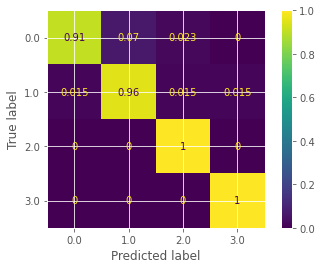

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# displaying confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_Xception_augment_1.png')

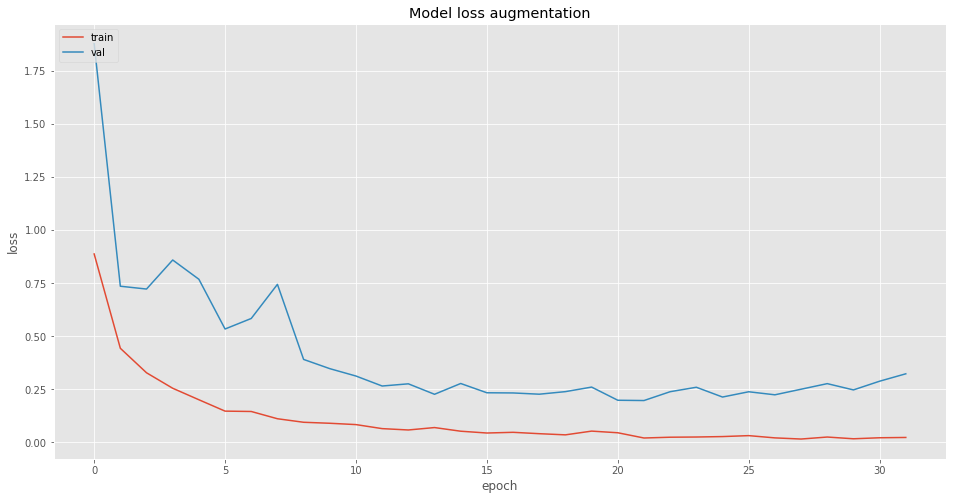

In [ ]:
import matplotlib.pyplot as plt


# plotting loss of model trained
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_Xception_augment_1.png')
plt.show()

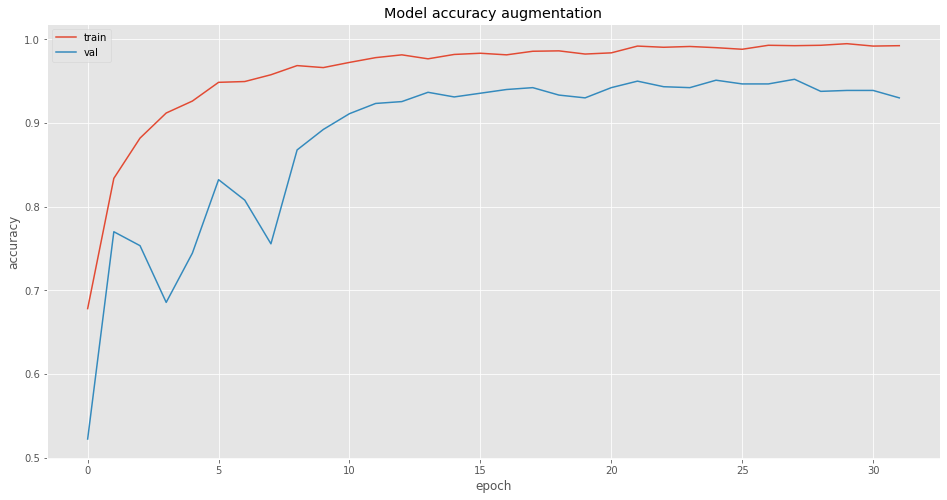

In [ ]:
import matplotlib.pyplot as plt

# plotting accuracy of model trained
plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_Xception_augment_1.png')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# showing accuracy of model
accuracy = accuracy_score(labels, predictions)
print(accuracy)

0.965


# EfficientNet

In [ ]:
import tensorflow as tf

# importing the efficientNetB4 model
efficient_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling='Average',
    classes=4,
    classifier_activation="softmax"
)

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Rescaling
from tensorflow.keras import models

# adding layers for intepretation of CNN output and classification layer
model = models.Sequential([
    efficient_model,
    Flatten(),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# callbacks to save the best model and stop training early once the validation loss no longer increases
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_efficient_augmented_3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
# training the model
history = model.fit(ds_train, validation_data=ds_validate, epochs = 50, callbacks=[es, mc])

In [ ]:
import numpy as np

# loading the best model for evaluation
model.load_weights('best_model_efficient_augmented_2.h5')

# creating all predictions so sklearn can be used to evalutate the model
predictions = np.array([])
labels =  np.array([])
for x, y in ds_validate:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])

  labels = np.concatenate([labels, y])

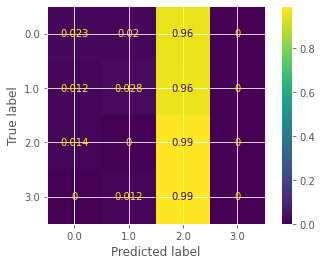

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# displaying confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='true')

confusion_matrix.figure_.savefig(os.getcwd() + '/figures/confusion_matrix_efficient_augment_3.png')

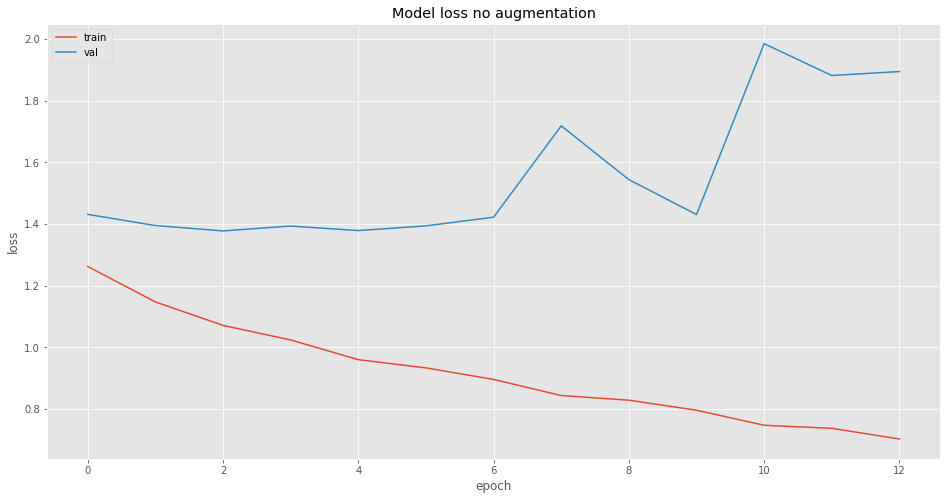

In [ ]:
import matplotlib.pyplot as plt


# plotting loss of model trained
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss no augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( os.getcwd() + '/figures/loss_efficientNetB4_augment_3.png')
plt.show()

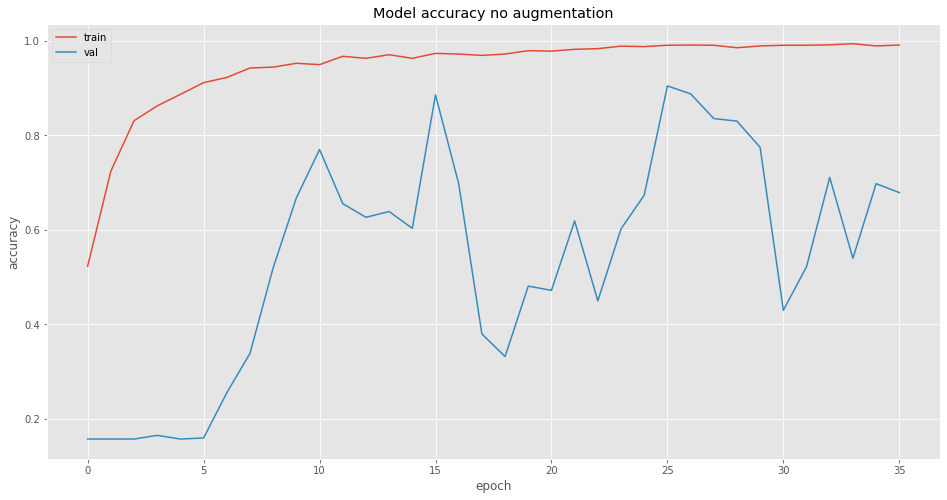

In [ ]:
import matplotlib.pyplot as plt

# plotting accuracy of model trained
plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy no augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig( './figures/accuracy_efficientNetB4_augment_2.png')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# showing accuracy of model
accuracy = accuracy_score(labels, predictions)
print(accuracy)

0.9044444444444445
